# Artificial Intelligence 🪐
# CA 5 -Convolutional Neural Networks (CNNs)

# Amirali Shahriary (810100173)

## Introduction:

In this project, we developed a convolutional neural network (CNN) for detecting suicidal tendencies in Twitter posts, aiming to categorize tweets into two classes: indicative of suicidal intent or not. By leveraging CNNs, which excel at capturing patterns in data, we adapted their architecture for text analysis. The model uses convolutional layers to extract key features from the text, followed by feed-forward layers for classification.Through this project, we explored the effectiveness of CNNs in text classification and optimized the model's performance using metrics like accuracy, recall, precision, and F1 score.

# Setup environment

In [41]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

In [42]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [43]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [44]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [47]:
# Load read and load the data here

df = pd.read_csv('/content/twitter-suicidal-data.csv')
print("head of csv:",df.head())
print ("ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★")
print("Columns in the dataset:", df.columns)
print ("ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★")
print(df.info())

head of csv:                                                tweet  intention
0  my life is meaningless i just want to end my l...          1
1  muttering i wanna die to myself daily for a fe...          1
2  work slave i really feel like my only purpose ...          1
3  i did something on the 2 of october i overdose...          1
4  i feel like no one cares i just want to die ma...          1
ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★
Columns in the dataset: Index(['tweet', 'intention'], dtype='object')
ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★ᯓ★
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB
None


## Data Preprocessing

In [48]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [49]:
def convert_emoji_to_text(text):
    """This function replaces emojis with a space."""
    return emoji.demojize(text, delimiters=(" ", " "))

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """
    # lowercase the text
    text = text.lower()

    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # remove usernames
    text = re.sub(r'@\w+', '', text)

    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # convert emojis to text
    text = convert_emoji_to_text(text)

    # remove non-word characters
    text = re.sub(r'\W+', ' ', text)

    # tokenize
    tokens = nltk.word_tokenize(text)

    # lemmatization and POS tagging
    nltk_tagged = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, nltk_pos_tagger(tag)) for token, tag in nltk_tagged]

    # remove stopwords
    tokens = [token for token in lemmatized_tokens if token not in stopwords]

    return tokens

In [50]:
# Show some samples before/after preprocessing
text_column = 'tweet'
sample_texts = df[text_column].sample(5).values
for text in sample_texts:
    print(f"Original: {text}")
    print(f"Processed: {' '.join(preprocess_data(text))}")
    print("-" * 40)

Original: feel worthless need a second opinion ive never been especially motivated to my repeated peril but recently last 4 months or so ive completely and wholly lost interest in anything and anyone i feel utterly shattered all the time and can barely get out of bed let alone go outside i spend almost all of my time either sleeping watching classic films or on the internet usually drinking at the same time my family are tolerating it for now but i suspect that they wont forever and i already find it draining to interact with them on a daily basis naturally i venomously loathe myself for being so useless and passive about everything and of course all of the usual suspects no prospects no experience no friends purely thanks to myself etc etc the only occasional bursts of energy are when i spontaneously break something or hurt myself like a child just as an outlet i keep having a recurring dream in whichi amlocked in a dark room with only a noose and a chair i spend a fair amount of my u

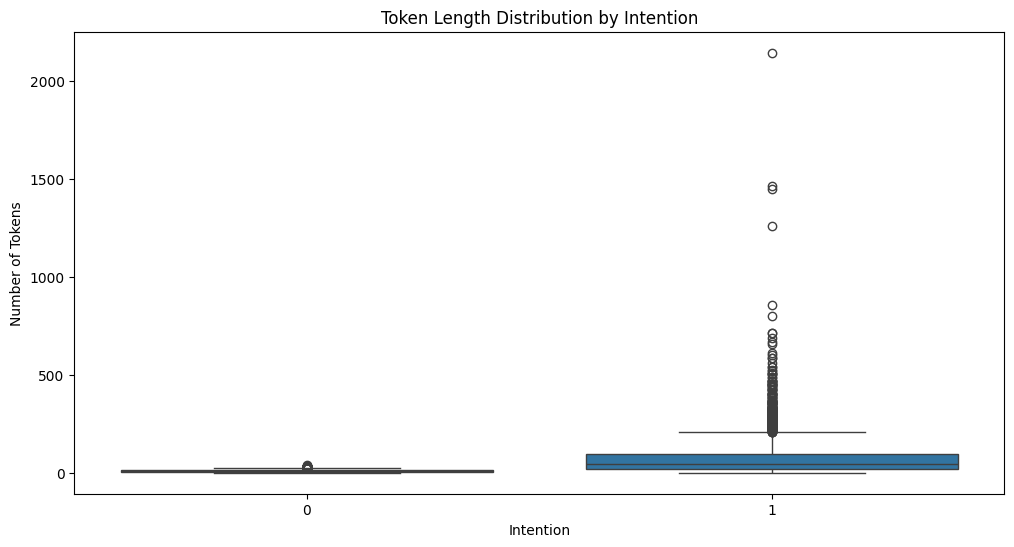

Summary statistics for token lengths:
count    9119.000000
mean       37.325145
std        71.783687
min         0.000000
25%         6.000000
50%        12.000000
75%        37.000000
max      2142.000000
Name: processed_text, dtype: float64


In [51]:
df['processed_text'] = df[text_column].apply(preprocess_data)

token_lengths = df['processed_text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='intention', y=token_lengths, data=df)
plt.title('Token Length Distribution by Intention')
plt.xlabel('Intention')
plt.ylabel('Number of Tokens')
plt.show()

print("Summary statistics for token lengths:")
print(token_lengths.describe())

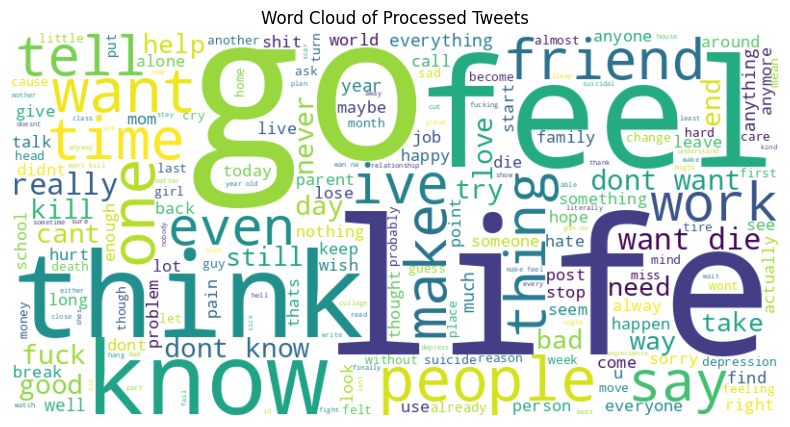

In [52]:
from wordcloud import WordCloud

all_words = ' '.join([' '.join(text) for text in df['processed_text']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Tweets')
plt.show()

### ● Briefly explain the advantages and disadvantages of converting the text to lowercase format and tell why we do this processing in the end?


#### Advantages:
- Normalization: Converting text to lowercase ensures that words like "Apple" and "apple" are treated as the same word. This helps in reducing the vocabulary size and normalizing the text data.

- Improved Matching: Lowercase conversion improves the matching of words during text analysis, as it eliminates the case sensitivity. This is particularly useful in search engines.

- Reduced Redundancy: By treating all variants of a word in different cases as the same, redundancy in the dataset is reduced.

- Simplified Processing: It simplifies downstream text processing tasks, such as tokenization, stemming, and lemmatization, by providing a consistent format for all text.

#### Disadvantages:
- Loss of Information: Sometimes, the case of a word can convey important information. For instance, "US" (United States) and "us" (pronoun) have different meanings, and converting to lowercase would lose this distinction.

- Reduced Readability: In some cases, converting text to lowercase might reduce readability, especially in documents where proper nouns and acronyms are significant.

- Context Loss: Certain applications might rely on case to provide context, such as in named entity recognition (NER), where the case of a word might indicate whether it is a person’s name, a location, etc.

#### Why Do We Convert Text to Lowercase?
- Converting text to lowercase is a common preprocessing step in NLP and text mining. The reasons for this are:

- Consistency: It ensures that the text is in a consistent format, which is essential for reliable text analysis and comparison.

- Efficiency: It reduces the complexity of text processing by treating words in different cases as the same, thereby simplifying algorithms and reducing the size of the vocabulary.

- Accuracy: By reducing the variability in the text, models can focus on learning meaningful patterns rather than getting distracted by case differences. This often leads to better performance in tasks like text classification, sentiment analysis, and other NLP applications.

- Data Cleaning: It is part of the general data cleaning process to prepare the text for further processing, ensuring that all text data is uniformly formatted, which is crucial for machine learning algorithms.



### ● Research the elimination of numbers in the above processes and name the advantages and disadvantages of this process.

#### Advantages:
- Noise Reduction: Numbers can sometimes introduce noise, especially if they are not relevant to the text analysis task.

Simplified Tokenization: Removing numbers can simplify the tokenization process. Numbers can create additional tokens that might not be useful and can complicate the analysis.

Vocabulary Size Reduction: Eliminating numbers reduces the size of the vocabulary, which can make models more efficient and faster to train, as they have fewer unique tokens to process.

Improved Focus: For certain tasks, removing numbers helps the model focus on the actual text content that carries more semantic meaning. This can be especially useful in text classification tasks where the presence of numbers might not be significant.

#### Disadvantages:
Loss of Information: Numbers can carry significant information, especially in contexts where they indicate quantities, dates, times, or specific identifiers.

Contextual Understanding: In some cases, numbers provide context that is critical to understanding the text. For instance, in financial documents, numbers are essential for analysis.

Named Entities: Numbers are often part of named entities (e.g., "Windows 10", "peugeot 206"). Removing them can distort the meaning of these entities.


### ● We have the ability to use hashtags in the Twitter social network. Explain why we did not remove these expressions and what effect does keeping them have on the performance of the model?

- Contextual Information:

Hashtags often encapsulate the core topic or sentiment of the tweet in a concise manner. For instance, hashtags like #PersianGulf or #FreeIran provide immediate context about the subject of the tweet.
- Topic Identification:

Hashtags are used to categorize tweets and help in identifying trending topics. This categorization is useful for topic modeling and clustering tasks where the goal is to group similar content.
- Sentiment and Emotion:

Many hashtags convey sentiments and emotions directly, such as #Love, #Excited, or #Sad. These can be critical for tasks like sentiment analysis where understanding the emotional tone of the tweet is important.
- Event Tracking:

Hashtags are frequently used to track events, campaigns, or movements (e.g., #BlackLivesMatter, #Elections1400). Keeping these can help in analyzing the impact and spread of such events over time.
- User Engagement:

They often reflect how users engage with specific topics and can be indicators of viral content. Analyzing hashtags can thus provide insights into user behavior and engagement patterns.

# Word2Vec - Word Embedding

In [53]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [12]:
W2V_PATH = None # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.


In [54]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

### ● based on word vector part Explain what methods there are to deal with non-existent words in the mentioned dictionary and name the advantages and disadvantages of each.

1. Ignore the Words
Method: Simply ignore or discard any words not found in the pre-trained dictionary.
Advantages:
Simplifies processing and reduces computational load.
Ensures that only high-quality, pre-validated word vectors are used.
Disadvantages:
Loss of potentially useful information.
Reduced context understanding, especially in domains with many out-of-vocabulary (OOV) words.
2. Use a Special Token
Method: Replace non-existent words with a special token (e.g., <UNK> for "unknown").
Advantages:
Provides a way to handle OOV words without losing entire sentences or documents.
Simplifies model implementation as all tokens are accounted for.
Disadvantages:
Can lead to information loss, as all unknown words are treated the same.
Overuse of the special token may reduce model performance, especially in texts with many OOV words.
3. Random Initialization
Method: Initialize non-existent words with random vectors.
Advantages:
Allows the model to learn representations for OOV words during training.
Preserves the structure of the input data without discarding words.
Disadvantages:
Randomly initialized vectors may not provide useful information initially.
Risk of adding noise to the model, which might affect convergence and performance.
4. Subword Embeddings (e.g., FastText)
Method: Use subword information to generate embeddings for OOV words based on character n-grams.
Advantages:
Effective for languages with rich morphology and compound words.
Can create meaningful representations for OOV words based on their components.
Disadvantages:
Increases computational complexity and model size.
May still struggle with entirely new or misspelled words.

5. Character-Level Embeddings
Method: Generate embeddings based on the characters in the word using RNNs, CNNs, or transformers.
Advantages:
Can handle any word, including OOV and misspelled words.
Captures morphological features of words.
Disadvantages:
Computationally more intensive.
Might require more data and training to achieve good performance.
6. Using a Backup Model
Method: Use a secondary, more comprehensive word vector model as a fallback (e.g., combining GloVe with FastText).
Advantages:
Improves coverage of words and reduces OOV instances.
Balances quality and coverage by leveraging multiple sources.
Disadvantages:
Increases complexity in preprocessing.
Potentially inconsistent embeddings due to different sources.

# Dataset

In [55]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size
        self.df_token_col = "tokens"
        self._proc_dataset()
        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        vector = self.dataframe.iloc[idx]["vector"]
        vector = vector.T
        intention = self.dataframe.iloc[idx]["intention"]
        return vector, intention

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].apply(self._pad)
        self.dataframe["vector"] = self.dataframe[self.df_token_col].apply(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        matrix = np.zeros((self.max_sequence_len, self.vector_size))
        for i, token in enumerate(tokens):
            if i < self.max_sequence_len:
                if token in self.w2v_model:
                    matrix[i] = self.w2v_model[token]
                else:
                    matrix[i] = np.zeros(self.vector_size)
        return torch.tensor(matrix, dtype=torch.float32).T

    def _pad(self, tokens: list):
        if len(tokens) < self.max_sequence_len:
            tokens += [''] * (self.max_sequence_len - len(tokens))
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = max(length_all)
        min_length = min(length_all)
        mean_length = sum(length_all) / len(length_all)
        return {
            "max_length": max_length,
            "min_length": min_length,
            "mean_length": mean_length,
        }

# Prepare Data

## Split Data into train-valid

In [56]:
# Split dataset into train-test split

from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [57]:
# create twitter dataset
train_dataset = Twitter(train_data, w2v_model, SEQUENCE_LEN)
test_dataset = Twitter(test_data, w2v_model, SEQUENCE_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_dataset = Twitter(train_df, w2v_model, sequence_len=64)
valid_dataset = Twitter(valid_df, w2v_model, sequence_len=64)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(test_dataset)}")

Deleted 0-Len Samples: 23


<ipython-input-55-e27d84cded44>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].apply(self._pad)
<ipython-input-55-e27d84cded44>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].apply(self._get_word_vectors)


Deleted 0-Len Samples: 8


<ipython-input-55-e27d84cded44>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].apply(self._pad)
<ipython-input-55-e27d84cded44>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].apply(self._get_word_vectors)


Deleted 0-Len Samples: 23


<ipython-input-55-e27d84cded44>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].apply(self._pad)
<ipython-input-55-e27d84cded44>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].apply(self._get_word_vectors)


Deleted 0-Len Samples: 8


<ipython-input-55-e27d84cded44>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].apply(self._pad)


Train dataset length: 7272
Valid dataset length: 1816
Train dataset length: 7272
Valid dataset length: 1816


<ipython-input-55-e27d84cded44>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].apply(self._get_word_vectors)


### ● What is the effect of kernel size in convolution layers and how is it effective in extracting input features? What does it mean to be more or less?



- Receptive Field:

 - Definition: The receptive field is the region of the input image that a convolutional kernel (or filter) "sees" at any given time.
 -Larger Kernels: With a larger kernel size, the receptive field is larger, allowing the network to capture more context and broader patterns from the input data.
 -Smaller Kernels: Smaller kernels,focus on finer, more local patterns and details. They capture less context but are more sensitive to small features in the data.
- Feature Extraction:

 - Larger Kernels: Effective at capturing high-level, abstract features and global patterns. They are useful in the early layers of deep networks where the goal is to identify broad characteristics of the input.
 - Smaller Kernels: Effective at capturing low-level, detailed features like edges, textures, and small shapes. They are useful in deeper layers where the network builds up complexity by combining these finer features into more complex patterns.
- Number of Parameters and Computational Cost:

 - Larger Kernels: Increase the number of parameters, leading to higher computational cost and memory usage.
 - Smaller Kernels: Decrease the number of parameters and computational cost. They are computationally efficient and often preferred in practice.

#### Effects
- More (Larger Kernels):

 - Pros:
Capture more context and broader patterns.
Effective in early layers for high-level feature extraction.
 - Cons:
Higher computational cost.
More parameters to train, leading to potential overfitting.
- Less (Smaller Kernels):

 - Pros:
Capture finer, detailed features.
Lower computational cost.
Often used in deeper architectures for hierarchical feature learning.
 - Cons:
May require more layers to capture broad patterns.

# Model and Train

## Utils

In [58]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

@torch.no_grad()
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = metrics.accuracy_score(all_labels, all_preds)
    return total_loss / len(test_loader), accuracy


@torch.no_grad()
def model_eval(model, loader, loss_function, device):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, total=len(loader), leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(loader)
    test_acc = correct / total
    return test_loss, test_acc

In [59]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def train_model(model, batch_size, loss_function, optimizer, epochs, train_set, valid_set, device):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, total=len(train_loader), leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        valid_loss, valid_acc = model_eval(model, valid_loader, loss_function, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history




In [60]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()



In [61]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    predicted = []

    for inputs, label in itr:
        inputs, label = inputs.to(device), label.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)
        labels.extend(label.cpu().numpy())
        predicted.extend(pred.cpu().numpy())

    cm = metrics.confusion_matrix(y_true=labels, y_pred=predicted)

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f")
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}

## Model's Network

In [62]:
class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN(input_size=300, num_classes=2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### ● Briefly explain how the Adam optimizer works and how it differs from the SGD optimizer.

#### Adam Optimizer
Mechanism:

##### Momentum: Adam uses the concept of momentum to smooth the updates. It computes the exponentially decaying average of past gradients (first moment estimate).
Adaptive Learning Rate: It also keeps track of the exponentially decaying average of past squared gradients (second moment estimate). This helps in adapting the learning rate for each parameter individually.
##### Steps:

\begin{align*}
& \text{Initialize parameters:} \\
& m_0 = 0 \quad \text{(first moment vector)} \\
& v_0 = 0 \quad \text{(second moment vector)} \\
& t = 0 \quad \text{(time step)} \\
& \alpha = \text{learning rate} \\
& \beta_1, \beta_2 \in [0, 1) \quad \text{(exponential decay rates)} \\
& \epsilon = 10^{-8} \quad \text{(small constant to prevent division by zero)} \\
\\
& \text{For each parameter update:} \\
& t \leftarrow t + 1 \\
& g_t \leftarrow \nabla_\theta J(\theta_t) \quad \text{(gradient of the loss function at time step t)} \\
& m_t \leftarrow \beta_1 m_{t-1} + (1 - \beta_1) g_t \quad \text{(update biased first moment estimate)} \\
& v_t \leftarrow \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \quad \text{(update biased second moment estimate)} \\
& \hat{m}_t \leftarrow \frac{m_t}{1 - \beta_1^t} \quad \text{(compute bias-corrected first moment estimate)} \\
& \hat{v}_t \leftarrow \frac{v_t}{1 - \beta_2^t} \quad \text{(compute bias-corrected second moment estimate)} \\
& \theta_t \leftarrow \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} \quad \text{(update parameters)}
\end{align*}


SGD Optimizer :

Basic Mechanism: SGD updates the parameters by computing the gradient of the loss function and moving the parameters in the opposite direction of the gradient. It uses a fixed learning rate for all parameters.


\begin{align*}
& \text{Initialize parameters:} \\
& \alpha = \text{learning rate} \\
\\
& \text{For each parameter update:} \\
& g_t \leftarrow \nabla_\theta J(\theta_t) \quad \text{(gradient of the loss function at time step t)} \\
& \theta_t \leftarrow \theta_{t-1} - \alpha g_t \quad \text{(update parameters)}
\end{align*}


#### Key Differences:

- Learning Rate: In SGD, the learning rate is fixed for all parameters, while Adam adjusts the learning rate individually for each parameter based on the first and second moment estimates.
- Momentum: While SGD can use momentum to help accelerate gradients vectors in the right directions, Adam incorporates momentum through the first moment estimate.
- Adaptive Learning Rates: Adam uses adaptive learning rates, adjusting them based on the past gradients. This helps in faster convergence and can handle sparse gradients better than vanilla SGD.
- Convergence: Adam often converges faster and is more robust to the choice of hyperparameters compared to SGD.




In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Reason for Using the Cross Entropy Loss Function:


- Nature of the Task: Our problem involves classifying tweets into different classes (e.g., tweets indicating suicidal intention vs. non-suicidal tweets). Cross Entropy Loss is well-suited for this type of classification (binary) task, where the goal is to assign probabilities to each class and minimize the difference between the predicted probability distribution and the actual distribution.

- Probability Distribution: Cross Entropy Loss measures the performance of a classification model whose output is a probability value between 0 and 1.

L(y, \hat{y}) = -[y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]


For multi-class classification, it extends to:

L(y, \hat{y}) = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)



- Penalizing Wrong Predictions: Cross Entropy Loss penalizes predictions that are confident and wrong more heavily than those that are less confident and wrong. This is critical in classification tasks where confident misclassifications are particularly undesirable.

Differentiability: The function is differentiable, making it suitable for optimization using gradient-based methods like SGD or Adam. This allows the model to update its parameters effectively during training.



### Why Convolution Output is Reduced Through Feed Forward Layers:


Transition from Convolutional Layers to Feed Forward Layers:

- Feature Extraction and Representation:

 -Convolutional Layers: These layers excel at capturing spatial hierarchies in the data through localized receptive fields. They effectively extract and encode features like edges, textures, shapes, and higher-level patterns from the input.
 - Feed Forward Layers: Once the convolutional layers have distilled the spatial information into a rich set of features, fully connected layers are used to interpret these features for final classification or regression tasks. This transition allows the network to leverage the high-level, abstract features learned by convolutional layers and make decisions based on them.
- Dimensionality Reduction:

 - Pooling Layers: Before transitioning to fully connected layers, pooling layers (e.g., max pooling) are often used to reduce the spatial dimensions of the feature maps while retaining important information. This reduces the computational burden and the number of parameters.
 - Flattening: The output from the convolutional layers (after pooling) is typically flattened into a 1D vector to be fed into the fully connected layers. This vector represents a compressed and abstract form of the input data.

##### Advantages of Using Feed Forward Layers for Reduction:
- High-Level Abstraction:
 Focus on local feature extraction and spatial hierarchies.
 Excel at integrating and interpreting the extracted features to make final decisions. They combine features from different parts of the image, allowing the network to understand complex patterns and relationships.
- Parameter Efficiency:

Convolutional Reduction and feed Forward Layers:
-
Flexibility and Generalization:

 By separating the network into specialized layers (convolutional for feature extraction and fully connected for decision making).

- Computational Efficiency:

Memory and Speed: Transitioning to fully connected layers after significant spatial reduction through pooling helps in managing memory usage and computational cost. Convolutional layers with large feature maps are computationally intensive, so reducing these maps before applying dense operations is efficient.


## Training

In [64]:
# Train the model

train_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
    test_loss, accuracy = evaluate(model, test_loader, criterion, DEVICE)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")


print ("⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐")

cnn_model_train_history = train_model(
    model=model,
    batch_size=32,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=20,
    train_set=train_dataset,
    valid_set=valid_dataset,
    device=device
)

Evaluating: 100%|██████████| 29/29 [00:00<00:00, 35.62it/s]


Epoch 1/15, Train Loss: 0.5089, Test Loss: 0.3434, Accuracy: 0.8524


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 31.46it/s]


Epoch 2/15, Train Loss: 0.3474, Test Loss: 0.3267, Accuracy: 0.8673


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 35.97it/s]


Epoch 3/15, Train Loss: 0.3288, Test Loss: 0.3023, Accuracy: 0.8816


Evaluating: 100%|██████████| 29/29 [00:01<00:00, 26.76it/s]


Epoch 4/15, Train Loss: 0.2993, Test Loss: 0.2866, Accuracy: 0.8827


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 35.43it/s]


Epoch 5/15, Train Loss: 0.2556, Test Loss: 0.2366, Accuracy: 0.9025


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 35.31it/s]


Epoch 6/15, Train Loss: 0.2142, Test Loss: 0.2180, Accuracy: 0.9091


Evaluating: 100%|██████████| 29/29 [00:01<00:00, 24.22it/s]


Epoch 7/15, Train Loss: 0.1850, Test Loss: 0.2151, Accuracy: 0.9097


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 36.51it/s]


Epoch 8/15, Train Loss: 0.1642, Test Loss: 0.2257, Accuracy: 0.9169


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 34.89it/s]


Epoch 9/15, Train Loss: 0.1507, Test Loss: 0.2207, Accuracy: 0.9069


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 32.04it/s]


Epoch 10/15, Train Loss: 0.1314, Test Loss: 0.2303, Accuracy: 0.9135


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 33.16it/s]


Epoch 11/15, Train Loss: 0.1127, Test Loss: 0.2529, Accuracy: 0.9036


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 36.29it/s]


Epoch 12/15, Train Loss: 0.1251, Test Loss: 0.2129, Accuracy: 0.9152


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 35.68it/s]


Epoch 13/15, Train Loss: 0.0748, Test Loss: 0.2659, Accuracy: 0.8992


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 35.83it/s]


Epoch 14/15, Train Loss: 0.0555, Test Loss: 0.2531, Accuracy: 0.9180


Evaluating: 100%|██████████| 29/29 [00:01<00:00, 22.86it/s]


Epoch 15/15, Train Loss: 0.0406, Test Loss: 0.3118, Accuracy: 0.9152
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐


Epoch 1/20, Train Loss: 0.1312, Train Acc: 0.9553, Valid Loss: 0.2573, Valid Acc: 0.9102


Epoch 2/20, Train Loss: 0.0722, Train Acc: 0.9725, Valid Loss: 0.2874, Valid Acc: 0.9009


Epoch 3/20, Train Loss: 0.0338, Train Acc: 0.9880, Valid Loss: 0.3909, Valid Acc: 0.9130


Epoch 4/20, Train Loss: 0.0325, Train Acc: 0.9889, Valid Loss: 0.3479, Valid Acc: 0.9207


Epoch 5/20, Train Loss: 0.0235, Train Acc: 0.9911, Valid Loss: 0.3379, Valid Acc: 0.9135


Epoch 6/20, Train Loss: 0.0139, Train Acc: 0.9957, Valid Loss: 0.3791, Valid Acc: 0.9185


Epoch 7/20, Train Loss: 0.0127, Train Acc: 0.9960, Valid Loss: 0.4673, Valid Acc: 0.9169


Epoch 8/20, Train Loss: 0.0097, Train Acc: 0.9970, Valid Loss: 0.4542, Valid Acc: 0.9174


Epoch 9/20, Train Loss: 0.0248, Train Acc: 0.9909, Valid Loss: 0.3871, Valid Acc: 0.9152


Epoch 10/20, Train Loss: 0.0176, Train Acc: 0.9941, Valid Loss: 0.4524, Valid Acc: 0.8959


Epoch 11/20, Train Loss: 0.0113, Train Acc: 0.9960, Valid Loss: 0.4158, Valid Acc: 0.9086


Epoch 12/20, Train Loss: 0.0085, Train Acc: 0.9971, Valid Loss: 0.4298, Valid Acc: 0.9124


Epoch 13/20, Train Loss: 0.0095, Train Acc: 0.9964, Valid Loss: 0.4328, Valid Acc: 0.9196


Epoch 14/20, Train Loss: 0.0075, Train Acc: 0.9967, Valid Loss: 0.4389, Valid Acc: 0.9163


Epoch 15/20, Train Loss: 0.0076, Train Acc: 0.9972, Valid Loss: 0.4466, Valid Acc: 0.9146


Epoch 16/20, Train Loss: 0.0084, Train Acc: 0.9972, Valid Loss: 0.4597, Valid Acc: 0.9119


Epoch 17/20, Train Loss: 0.0095, Train Acc: 0.9971, Valid Loss: 0.4429, Valid Acc: 0.9180


Epoch 18/20, Train Loss: 0.0066, Train Acc: 0.9978, Valid Loss: 0.4420, Valid Acc: 0.9075


Epoch 19/20, Train Loss: 0.0071, Train Acc: 0.9972, Valid Loss: 0.4526, Valid Acc: 0.9196


Epoch 20/20, Train Loss: 0.0063, Train Acc: 0.9971, Valid Loss: 0.4540, Valid Acc: 0.9196


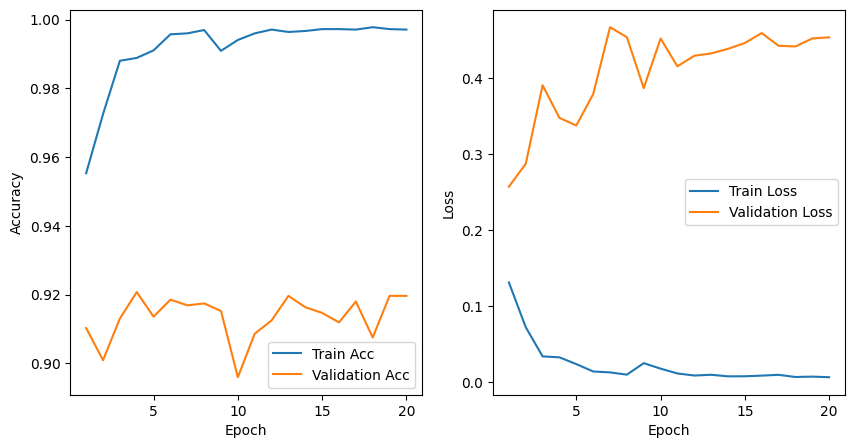

In [65]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

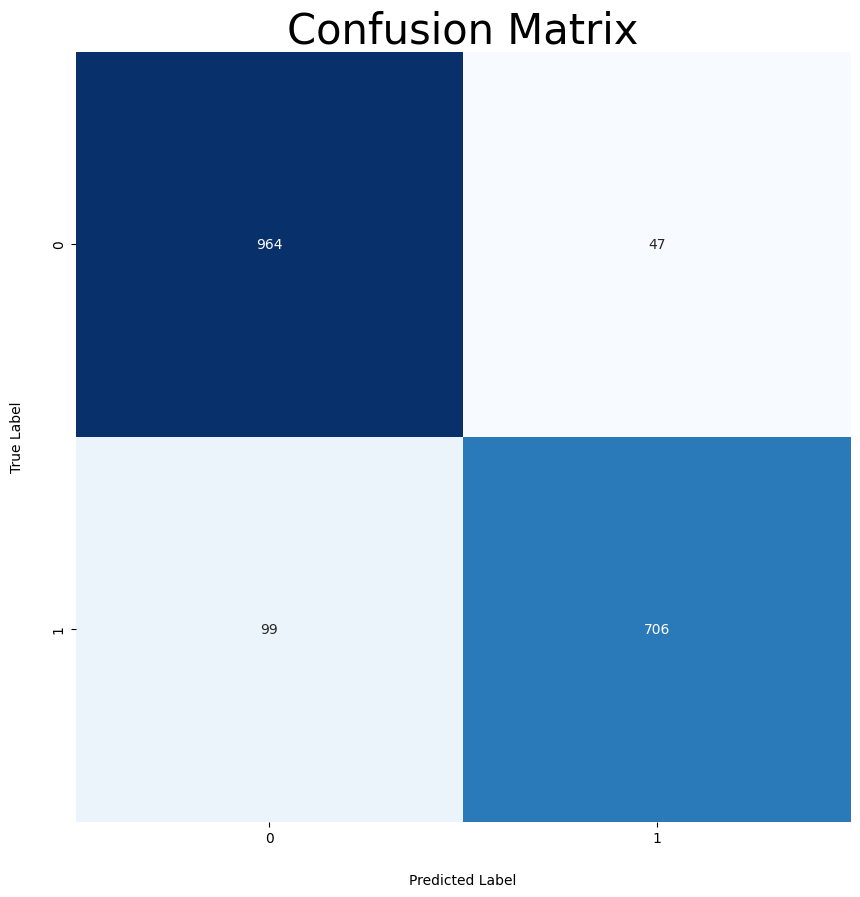

In [66]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [67]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.915
F1:        0.918
Precision: 0.922
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1011
           1       0.94      0.88      0.91       805

    accuracy                           0.92      1816
   macro avg       0.92      0.92      0.92      1816
weighted avg       0.92      0.92      0.92      1816



## Part 3: the effect of the size of the text window on model learning:



### ● In your opinion, what are the advantages and disadvantages of increasing the size of the text window, so that it is larger than the entire dataset, in a convolutional neural network?

#### Advantages:
- Capturing Long-Range Dependencies:

Contextual Understanding: A larger text window allows the network to capture long-range dependencies and relationships between distant words in the text.

Improved Accuracy: By considering a larger portion of the text, the model can potentially achieve better accuracy in tasks like text classification, sentiment analysis, and named entity recognition.
- Reduced Need for Stacking Layers:

Efficiency: Instead of stacking multiple convolutional layers to increase the receptive field, a larger text window can achieve a wide context in fewer layers.

Simplified Architecture: It simplifies the network architecture by reducing the number of required layers to achieve the desired receptive field size.


#### Disadvantages:
- Increased Computational Cost:

Resource Intensive: Processing larger text windows requires more computational resources.

Scalability Issues: As the text window size increases, the model may become less scalable.

- Overfitting Risk:

 With a larger text window, the model may overfit to the training data, learning specific details that do not generalize well to unseen data.

- Data Sparsity and Irrelevance:

 A larger text window might include irrelevant information, especially if the entire dataset's context is not always necessary for the task at hand. This can confuse the model and degrade performance.
Sparse Signals: In some cases, the relevant information might become sparse relative to the window size, making it harder for the model to learn effectively.

In [68]:
train_dataframe, valid_dataframe = train_test_split(df, test_size=0.2, random_state=42)

# Define a larger sequence length
LARGE_SEQUENCE_LEN = 196

# Create twitter datasets with the new sequence length
train_dataset_large = Twitter(
    dataframe=train_dataframe,
    w2v_model=w2v_model,
    sequence_len=LARGE_SEQUENCE_LEN
)
valid_dataset_large = Twitter(
    dataframe=valid_dataframe,
    w2v_model=w2v_model,
    sequence_len=LARGE_SEQUENCE_LEN
)

print(f"Train dataset length: {len(train_dataset_large)}")
print(f"Valid dataset length: {len(valid_dataset_large)}")



Deleted 0-Len Samples: 23


<ipython-input-55-e27d84cded44>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].apply(self._pad)
<ipython-input-55-e27d84cded44>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].apply(self._get_word_vectors)


Deleted 0-Len Samples: 8


<ipython-input-55-e27d84cded44>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].apply(self._pad)


Train dataset length: 7272
Valid dataset length: 1816


<ipython-input-55-e27d84cded44>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].apply(self._get_word_vectors)


In [69]:
class CNNLargeWindow(nn.Module):
    def __init__(self):
        super(CNNLargeWindow, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 22, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Transpose the input tensor to the expected shape
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_large_window = CNNLargeWindow()


In [70]:
# loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_large_window.parameters(), lr=0.01)

# Train
cnn_model_train_history_large_window = train_model(
    model=model_large_window,
    batch_size=32,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=20,
    train_set=train_dataset_large,
    valid_set=valid_dataset_large,
    device=device
)


Epoch 1/20, Train Loss: 0.6857, Train Acc: 0.5609, Valid Loss: 0.6826, Valid Acc: 0.5567


Epoch 2/20, Train Loss: 0.6773, Train Acc: 0.5609, Valid Loss: 0.6703, Valid Acc: 0.5567


Epoch 3/20, Train Loss: 0.6444, Train Acc: 0.6469, Valid Loss: 0.5850, Valid Acc: 0.8172


Epoch 4/20, Train Loss: 0.4620, Train Acc: 0.8324, Valid Loss: 0.3645, Valid Acc: 0.8458


Epoch 5/20, Train Loss: 0.3681, Train Acc: 0.8340, Valid Loss: 0.3464, Valid Acc: 0.8480


Epoch 6/20, Train Loss: 0.3592, Train Acc: 0.8366, Valid Loss: 0.3398, Valid Acc: 0.8524


Epoch 7/20, Train Loss: 0.3548, Train Acc: 0.8434, Valid Loss: 0.3370, Valid Acc: 0.8530


Epoch 8/20, Train Loss: 0.3506, Train Acc: 0.8457, Valid Loss: 0.3331, Valid Acc: 0.8552


Epoch 9/20, Train Loss: 0.3464, Train Acc: 0.8515, Valid Loss: 0.3297, Valid Acc: 0.8601


Epoch 10/20, Train Loss: 0.3437, Train Acc: 0.8534, Valid Loss: 0.3266, Valid Acc: 0.8612


Epoch 11/20, Train Loss: 0.3390, Train Acc: 0.8563, Valid Loss: 0.3229, Valid Acc: 0.8634


Epoch 12/20, Train Loss: 0.3348, Train Acc: 0.8592, Valid Loss: 0.3189, Valid Acc: 0.8667


Epoch 13/20, Train Loss: 0.3309, Train Acc: 0.8626, Valid Loss: 0.3147, Valid Acc: 0.8717


Epoch 14/20, Train Loss: 0.3259, Train Acc: 0.8667, Valid Loss: 0.3108, Valid Acc: 0.8778


Epoch 15/20, Train Loss: 0.3201, Train Acc: 0.8681, Valid Loss: 0.3062, Valid Acc: 0.8778


Epoch 16/20, Train Loss: 0.3149, Train Acc: 0.8722, Valid Loss: 0.3027, Valid Acc: 0.8805


Epoch 17/20, Train Loss: 0.3093, Train Acc: 0.8733, Valid Loss: 0.2969, Valid Acc: 0.8827


Epoch 18/20, Train Loss: 0.3031, Train Acc: 0.8775, Valid Loss: 0.2910, Valid Acc: 0.8877


Epoch 19/20, Train Loss: 0.2968, Train Acc: 0.8819, Valid Loss: 0.2849, Valid Acc: 0.8893


Epoch 20/20, Train Loss: 0.2905, Train Acc: 0.8861, Valid Loss: 0.2796, Valid Acc: 0.8937


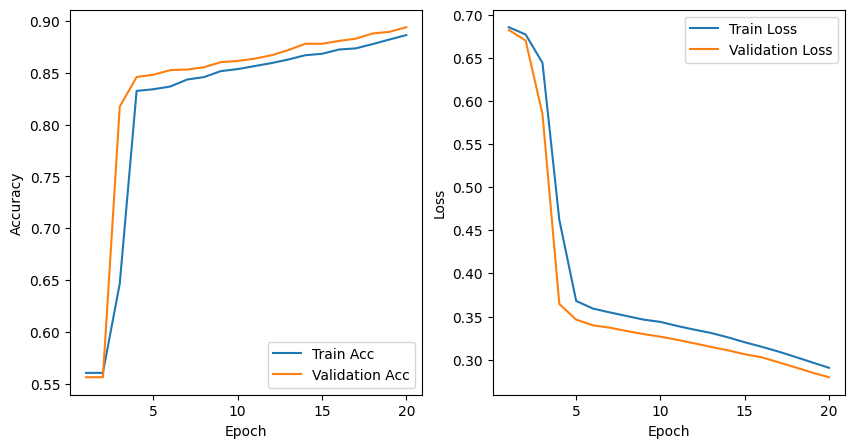

In [71]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_large_window["train_acc"]),
            ("Validation Acc", cnn_model_train_history_large_window["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_large_window["train_loss"]),
            ("Validation Loss", cnn_model_train_history_large_window["valid_loss"])
        ]
    }
)

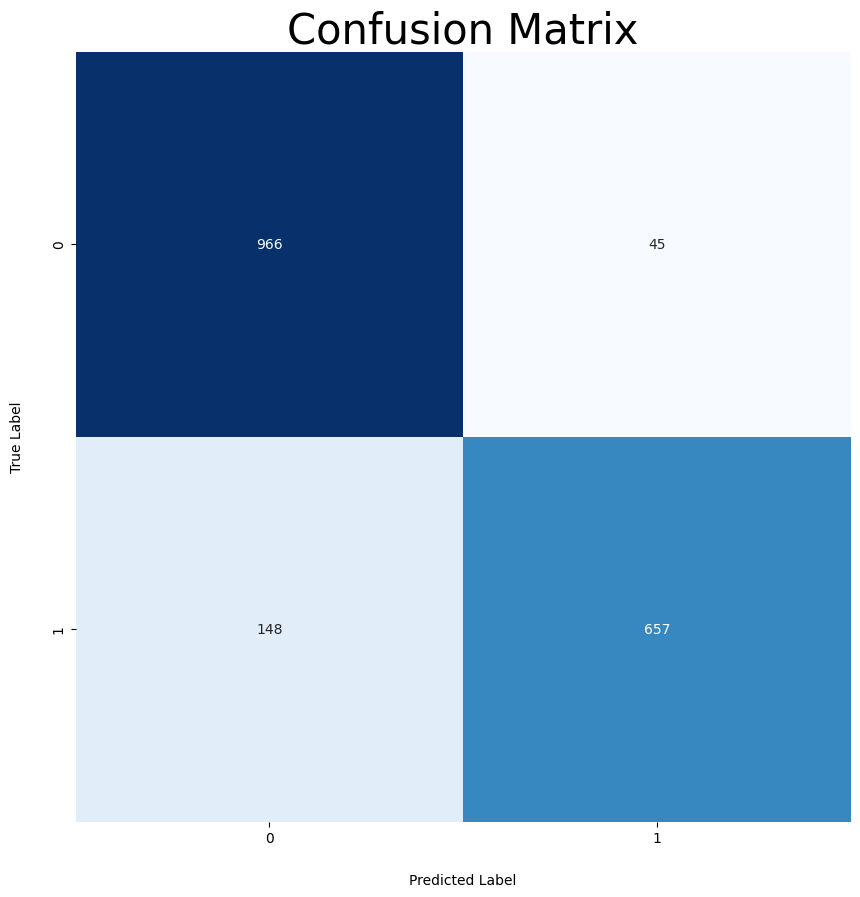

In [72]:
cnn_model_report_large_window = generate_confusion_matrix(
    model=model_large_window,
    dataset=valid_dataset_large,
)




In [73]:
print(f"Recall:    {cnn_model_report_large_window['recall']:.3f}")
print(f"F1:        {cnn_model_report_large_window['f1']:.3f}")
print(f"Precision: {cnn_model_report_large_window['precision']:.3f}")
print(cnn_model_report_large_window['report'])

Recall:    0.886
F1:        0.891
Precision: 0.902
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1011
           1       0.94      0.82      0.87       805

    accuracy                           0.89      1816
   macro avg       0.90      0.89      0.89      1816
weighted avg       0.90      0.89      0.89      1816





## Part 4: The impact of regularization methods

In [74]:
class CNNWithRegularization(nn.Module):
    def __init__(self):
        super(CNNWithRegularization, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 22, 128)  # Adjusted for 22 length after conv and pooling layers
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model_with_reg = CNNWithRegularization()

In [75]:
# loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_with_reg.parameters(), lr=0.01)

# Train
cnn_model_train_history_with_reg = train_model(
    model=model_with_reg,
    batch_size=32,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=20,
    train_set=train_dataset_large,
    valid_set=valid_dataset_large,
    device=device
)



Epoch 1/20, Train Loss: 0.3691, Train Acc: 0.8431, Valid Loss: 0.2993, Valid Acc: 0.8711


Epoch 2/20, Train Loss: 0.2728, Train Acc: 0.8830, Valid Loss: 0.3002, Valid Acc: 0.8563


Epoch 3/20, Train Loss: 0.1885, Train Acc: 0.9255, Valid Loss: 0.6340, Valid Acc: 0.7010


Epoch 4/20, Train Loss: 0.1235, Train Acc: 0.9575, Valid Loss: 0.2531, Valid Acc: 0.9047


Epoch 5/20, Train Loss: 0.0751, Train Acc: 0.9730, Valid Loss: 0.5237, Valid Acc: 0.8893


Epoch 6/20, Train Loss: 0.0494, Train Acc: 0.9835, Valid Loss: 0.3355, Valid Acc: 0.8877


Epoch 7/20, Train Loss: 0.0416, Train Acc: 0.9854, Valid Loss: 0.4463, Valid Acc: 0.8579


Epoch 8/20, Train Loss: 0.0260, Train Acc: 0.9928, Valid Loss: 0.3425, Valid Acc: 0.9064


Epoch 9/20, Train Loss: 0.0171, Train Acc: 0.9956, Valid Loss: 0.3656, Valid Acc: 0.9009


Epoch 10/20, Train Loss: 0.0138, Train Acc: 0.9963, Valid Loss: 0.3723, Valid Acc: 0.9058


Epoch 11/20, Train Loss: 0.0093, Train Acc: 0.9977, Valid Loss: 0.3930, Valid Acc: 0.9069


Epoch 12/20, Train Loss: 0.0124, Train Acc: 0.9959, Valid Loss: 0.4314, Valid Acc: 0.9069


Epoch 13/20, Train Loss: 0.0086, Train Acc: 0.9970, Valid Loss: 0.3916, Valid Acc: 0.9036


Epoch 14/20, Train Loss: 0.0081, Train Acc: 0.9977, Valid Loss: 0.4076, Valid Acc: 0.9069


Epoch 15/20, Train Loss: 0.0085, Train Acc: 0.9971, Valid Loss: 0.4184, Valid Acc: 0.9069


Epoch 16/20, Train Loss: 0.0089, Train Acc: 0.9968, Valid Loss: 0.4488, Valid Acc: 0.8915


Epoch 17/20, Train Loss: 0.0081, Train Acc: 0.9968, Valid Loss: 0.4138, Valid Acc: 0.9080


Epoch 18/20, Train Loss: 0.0066, Train Acc: 0.9979, Valid Loss: 0.4503, Valid Acc: 0.9042


Epoch 19/20, Train Loss: 0.0061, Train Acc: 0.9979, Valid Loss: 0.4743, Valid Acc: 0.9102


Epoch 20/20, Train Loss: 0.0072, Train Acc: 0.9975, Valid Loss: 0.4598, Valid Acc: 0.9058


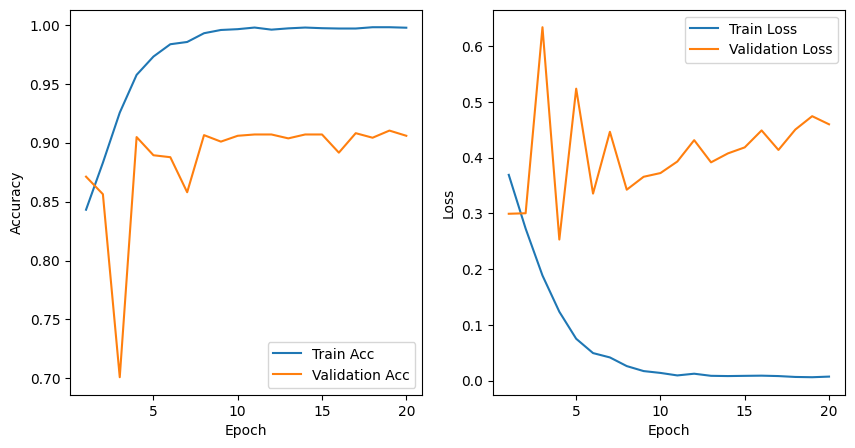

In [77]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_with_reg["train_acc"]),
            ("Validation Acc", cnn_model_train_history_with_reg["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_with_reg["train_loss"]),
            ("Validation Loss", cnn_model_train_history_with_reg["valid_loss"])
        ]
    }
)



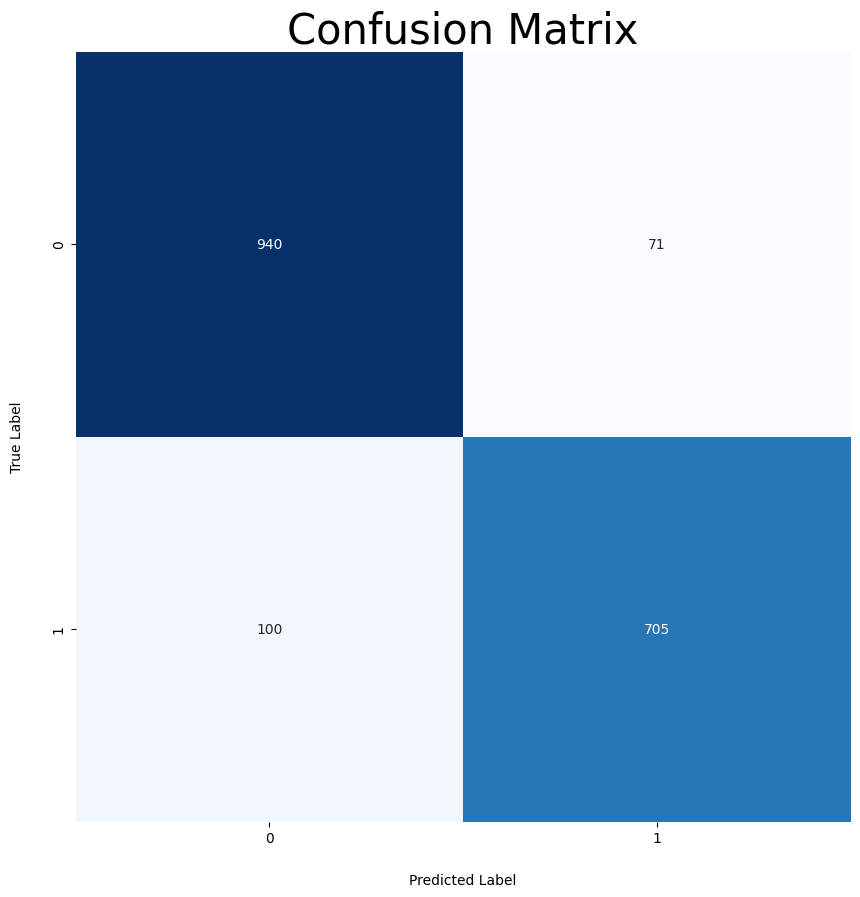

In [78]:
cnn_model_report_with_reg = generate_confusion_matrix(
    model=model_with_reg,
    dataset=valid_dataset_large,
)



In [79]:
print(f"Recall:    {cnn_model_report_with_reg['recall']:.3f}")
print(f"F1:        {cnn_model_report_with_reg['f1']:.3f}")
print(f"Precision: {cnn_model_report_with_reg['precision']:.3f}")
print(cnn_model_report_with_reg['report'])


Recall:    0.903
F1:        0.904
Precision: 0.906
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1011
           1       0.91      0.88      0.89       805

    accuracy                           0.91      1816
   macro avg       0.91      0.90      0.90      1816
weighted avg       0.91      0.91      0.91      1816



                                        🌌